In [10]:
!pip install torch transformers sentence-transformers scikit-learn numpy

In [30]:
pip install matplotlib seaborn

In [11]:
import torch
import numpy as np
import random
from transformers import BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import IncrementalPCA
from torch import nn, optim
from collections import deque
import os

In [12]:
# Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EMBED_DIM = 128
SEQ_LENGTH = 5  # Number of sentences in our sample

In [21]:
SENTENCES = [
    "A playful dog ran towards him, wagging its tail",
     "He threw the ball high into the air, watching it spin",
    "The boy picked up a shiny red ball from the grass",
    "Laughing, the boy ran forward to play again",
    "The dog leaped up and caught it in its mouth"
]

In [22]:
class BERTRewardCalculator:
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.sbert = SentenceTransformer('all-mpnet-base-v2').to(DEVICE)
        self.bert = BertModel.from_pretrained('bert-base-uncased').to(DEVICE)
        self.pca = IncrementalPCA(n_components=EMBED_DIM)

        for model in [self.bert, self.sbert]:
            for param in model.parameters():
                param.requires_grad = False

    def get_embeddings(self, texts):
        with torch.no_grad():
            sbert_embeds = self.sbert.encode(texts, convert_to_tensor=True)
            sbert_embeds = sbert_embeds.cpu().numpy()

        if not hasattr(self.pca, 'components_'):
            self.pca.fit(sbert_embeds)
        return self.pca.transform(sbert_embeds)

    def sequence_coherence(self, sequence):
        inputs = self.tokenizer(
            [f"{sequence[i]} [SEP] {sequence[i+1]}" for i in range(len(sequence)-1)],
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=64
        ).to(DEVICE)

        with torch.no_grad():
            outputs = self.bert(**inputs)
            cls_embeds = outputs.last_hidden_state[:, 0, :]

        similarities = torch.cosine_similarity(cls_embeds[:-1], cls_embeds[1:])
        return torch.mean(similarities).item()

In [23]:
class SequenceEnvironment:
    def __init__(self, sentences, rewarder):
        self.sentences = sentences
        self.rewarder = rewarder
        self.n = len(sentences)
        self.embeddings = self.rewarder.get_embeddings(sentences)
        self.reset()

    def reset(self):
        self.current_order = np.random.permutation(self.n).tolist()
        return self._get_state()

    def _get_state(self):
        embeds = self.embeddings[self.current_order]
        positions = np.arange(self.n)[:, np.newaxis] / self.n
        return np.hstack([embeds, positions]).flatten()

    def step(self, action):
        src, dst = action
        item = self.current_order.pop(src)
        self.current_order.insert(dst, item)

        reward = self._calculate_reward()
        done = False  # Continuous learning
        return self._get_state(), reward, done

    def _calculate_reward(self):
        sequence = [self.sentences[i] for i in self.current_order]
        return self.rewarder.sequence_coherence(sequence)

In [24]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [25]:
class DQNAgent:
    def __init__(self, input_dim, output_dim):
        self.q_net = DQN(input_dim, output_dim).to(DEVICE)
        self.target_net = DQN(input_dim, output_dim).to(DEVICE)
        self.optimizer = optim.AdamW(self.q_net.parameters(), lr=0.0001)
        self.memory = deque(maxlen=10000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, SEQ_LENGTH-1), random.randint(0, SEQ_LENGTH-1)

        state_t = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            q_values = self.q_net(state_t)
        action_idx = torch.argmax(q_values).item()
        return (action_idx // SEQ_LENGTH, action_idx % SEQ_LENGTH)

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(DEVICE)
        next_states = torch.FloatTensor(np.array(next_states)).to(DEVICE)
        rewards = torch.FloatTensor(rewards).to(DEVICE)

        current_q = self.q_net(states).gather(1,
            torch.LongTensor([a[0]*SEQ_LENGTH + a[1] for a in actions]).unsqueeze(1).to(DEVICE))
        next_q = self.target_net(next_states).max(1)[0]
        target_q = rewards + self.gamma * next_q

        loss = nn.MSELoss()(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(0.01, self.epsilon*0.995)
        self.target_net.load_state_dict(self.q_net.state_dict())

In [26]:
def main():
    # Initialize components
    rewarder = BERTRewardCalculator()
    env = SequenceEnvironment(SENTENCES, rewarder)
    agent = DQNAgent(
        input_dim=len(env.reset()),
        output_dim=SEQ_LENGTH**2
    )

    # Tracking the best sequence
    best_reward = float('-inf')
    best_sequence = None

    # Training loop
    print("Starting training...")
    for episode in range(1000):
        state = env.reset()
        total_reward = 0

        for _ in range(50):  # Steps per episode
            action = agent.act(state)
            next_state, reward, _ = env.step(action)
            agent.remember(state, action, reward, next_state)
            agent.learn()
            total_reward += reward
            state = next_state

        # Check if the current sequence is the best so far
        if total_reward > best_reward:
            best_reward = total_reward
            best_sequence = env.current_order[:]  # Store a copy of the best order

        if (episode+1) % 50 == 0:
            print(f"Episode {episode+1}, Avg Reward: {total_reward/50:.3f}, Epsilon: {agent.epsilon:.3f}")

    # Show the sequence with the highest reward
    print("\nBest Sequence Found:")
    for idx, order in enumerate(best_sequence):
        print(f"{idx+1}. {SENTENCES[order]}")

In [29]:
if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_incremental_pca.py:376: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Starting training...
Episode 50, Avg Reward: 0.954, Epsilon: 0.010
Episode 100, Avg Reward: 0.955, Epsilon: 0.010
Episode 150, Avg Reward: 0.952, Epsilon: 0.010
Episode 200, Avg Reward: 0.953, Epsilon: 0.010
Episode 250, Avg Reward: 0.957, Epsilon: 0.010
Episode 300, Avg Reward: 0.955, Epsilon: 0.010
Episode 350, Avg Reward: 0.952, Epsilon: 0.010
Episode 400, Avg Reward: 0.953, Epsilon: 0.010
Episode 450, Avg Reward: 0.954, Epsilon: 0.010
Episode 500, Avg Reward: 0.953, Epsilon: 0.010
Episode 550, Avg Reward: 0.954, Epsilon: 0.010
Episode 600, Avg Reward: 0.954, Epsilon: 0.010
Episode 650, Avg Reward: 0.953, Epsilon: 0.010
Episode 700, Avg Reward: 0.957, Epsilon: 0.010
Episode 750, Avg Reward: 0.953, Epsilon: 0.010
Episode 800, Avg Reward: 0.956, Epsilon: 0.010
Episode 850, Avg Reward: 0.954, Epsilon: 0.010
Episode 900, Avg Reward: 0.952, Epsilon: 0.010
Episode 950, Avg Reward: 0.955, Epsilon: 0.010
Episode 1000, Avg Reward: 0.954, Epsilon: 0.010

Best Sequence Found:
1. The dog leaped

In [34]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# Add these helper functions
def calculate_diversity(sequence, n=3):
    total_ngrams = 0
    unique_ngrams = set()

    for sentence in sequence:
        words = sentence.split()
        sentence_ngrams = zip(*[words[i:] for i in range(n)])
        for gram in sentence_ngrams:
            unique_ngrams.add(gram)
            total_ngrams += 1

    return len(unique_ngrams) / total_ngrams if total_ngrams > 0 else 0

def plot_training_metrics(metrics):
    plt.figure(figsize=(15, 5))

    # Plot Average Reward
    plt.subplot(1, 3, 1)
    plt.plot(metrics['episodes'], metrics['avg_rewards'], label='Average Reward')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('Training Rewards')
    plt.grid(True)

    # Plot Coherence Scores
    plt.subplot(1, 3, 2)
    plt.plot(metrics['episodes'], metrics['coherence_scores'], color='orange')
    plt.xlabel('Episodes')
    plt.ylabel('Coherence Score')
    plt.title('Sequence Coherence Progress')
    plt.grid(True)

    # Plot Diversity Scores
    plt.subplot(1, 3, 3)
    plt.plot(metrics['episodes'], metrics['diversity_scores'], color='green')
    plt.xlabel('Episodes')
    plt.ylabel('Diversity Score')
    plt.title('Sequence Diversity Progress')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

def print_sequence_comparison(original, optimized):
    print("\n\nSequence Comparison:")
    print(f"{'Original':^40} | {'Optimized':^40}")
    print("-"*85)
    for o, opt in zip(original, optimized):
        print(f"{o[:35]:<40} | {opt[:35]:<40}")

In [35]:
rewarder = BERTRewardCalculator()
env = SequenceEnvironment(SENTENCES, rewarder)
agent = DQNAgent(
    input_dim=len(env.reset()),
    output_dim=SEQ_LENGTH**2
)

# Initialize metrics tracking
training_metrics = {
    'episodes': [],
    'avg_rewards': [],
    'coherence_scores': [],
    'diversity_scores': []
}

best_reward = float('-inf')
best_sequence = None
original_sequence = SENTENCES.copy()

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_incremental_pca.py:376: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [36]:
print("Starting training...")
for episode in range(1000):
    state = env.reset()
    episode_rewards = []
    episode_coherence = []
    episode_diversity = []

    for _ in range(50):
        action = agent.act(state)
        next_state, reward, _ = env.step(action)
        agent.remember(state, action, reward, next_state)
        agent.learn()

        # Store metrics
        episode_rewards.append(reward)
        current_sequence = [SENTENCES[i] for i in env.current_order]
        episode_coherence.append(rewarder.sequence_coherence(current_sequence))
        episode_diversity.append(calculate_diversity(current_sequence))

        state = next_state

    # Update best sequence
    total_reward = sum(episode_rewards)
    if total_reward > best_reward:
        best_reward = total_reward
        best_sequence = [SENTENCES[i] for i in env.current_order]

    # Record metrics
    training_metrics['episodes'].append(episode)
    training_metrics['avg_rewards'].append(np.mean(episode_rewards))
    training_metrics['coherence_scores'].append(np.mean(episode_coherence))
    training_metrics['diversity_scores'].append(np.mean(episode_diversity))

    if (episode+1) % 50 == 0:
        print(f"Episode {episode+1}")
        print(f"  Avg Reward: {np.mean(episode_rewards):.3f}")
        print(f"  Coherence: {np.mean(episode_coherence):.3f}")
        print(f"  Diversity: {np.mean(episode_diversity):.3f}")
        print(f"  Epsilon: {agent.epsilon:.3f}\n")

Starting training...
Episode 50
  Avg Reward: 0.949
  Coherence: 0.949
  Diversity: 1.000
  Epsilon: 0.010

Episode 100
  Avg Reward: 0.952
  Coherence: 0.952
  Diversity: 1.000
  Epsilon: 0.010

Episode 150
  Avg Reward: 0.952
  Coherence: 0.952
  Diversity: 1.000
  Epsilon: 0.010

Episode 200
  Avg Reward: 0.953
  Coherence: 0.953
  Diversity: 1.000
  Epsilon: 0.010

Episode 250
  Avg Reward: 0.950
  Coherence: 0.950
  Diversity: 1.000
  Epsilon: 0.010

Episode 300
  Avg Reward: 0.950
  Coherence: 0.950
  Diversity: 1.000
  Epsilon: 0.010

Episode 350
  Avg Reward: 0.953
  Coherence: 0.953
  Diversity: 1.000
  Epsilon: 0.010

Episode 400
  Avg Reward: 0.955
  Coherence: 0.955
  Diversity: 1.000
  Epsilon: 0.010

Episode 450
  Avg Reward: 0.955
  Coherence: 0.955
  Diversity: 1.000
  Epsilon: 0.010

Episode 500
  Avg Reward: 0.952
  Coherence: 0.952
  Diversity: 1.000
  Epsilon: 0.010

Episode 550
  Avg Reward: 0.956
  Coherence: 0.956
  Diversity: 1.000
  Epsilon: 0.010

Episode 600


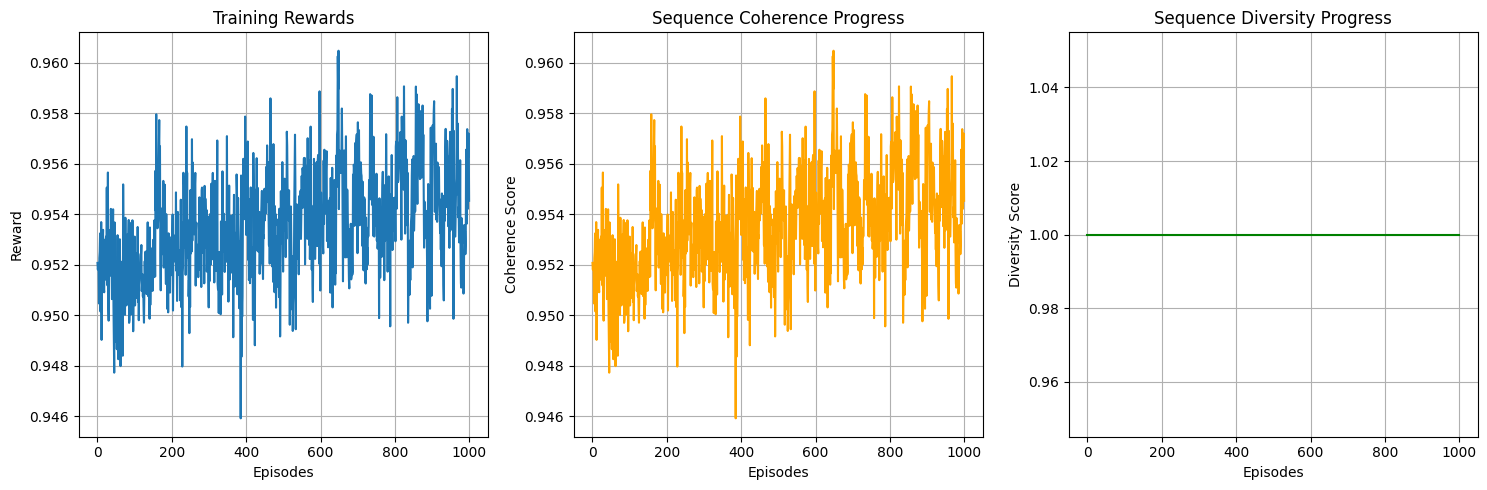

In [37]:
# Plotting and results
plot_training_metrics(training_metrics)

In [38]:
print("\nFinal Metrics:")
print(f"Max Coherence Achieved: {max(training_metrics['coherence_scores']):.3f}")
print(f"Max Diversity Achieved: {max(training_metrics['diversity_scores']):.3f}")


Final Metrics:
Max Coherence Achieved: 0.960
Max Diversity Achieved: 1.000


In [39]:
print_sequence_comparison(original_sequence, best_sequence)



Sequence Comparison:
                Original                 |                Optimized                
-------------------------------------------------------------------------------------
A playful dog ran towards him, wagg      | The dog leaped up and caught it in      
He threw the ball high into the air      | Laughing, the boy ran forward to pl     
The boy picked up a shiny red ball       | A playful dog ran towards him, wagg     
Laughing, the boy ran forward to pl      | He threw the ball high into the air     
The dog leaped up and caught it in       | The boy picked up a shiny red ball      


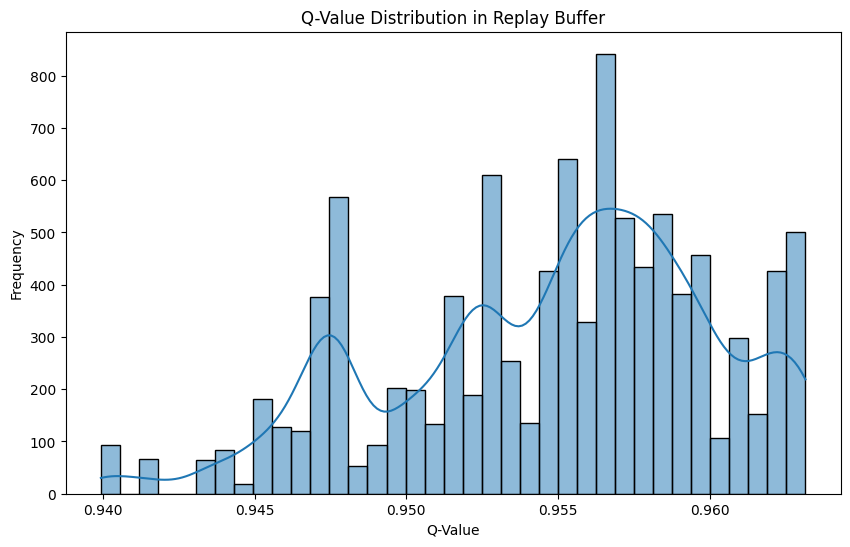

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract rewards from memory (assuming each entry is (state, action, reward, next_state))
reward_data = [experience[2] for experience in agent.memory]

# Convert to DataFrame
df = pd.DataFrame(reward_data, columns=['reward'])

# Plot Q-value distributions
plt.figure(figsize=(10, 6))
sns.histplot(df, x='reward', kde=True)
plt.title('Q-Value Distribution in Replay Buffer')
plt.xlabel('Q-Value')
plt.ylabel('Frequency')
plt.savefig('q_value_distribution.png')
plt.show()